V1 includes:

- For IRR: calculating future IRRs based on targets

- For MOIC: adding graph of target and value of Break even (P&I based on 10% a year)

In [1]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
import pandas_gbq
import numpy_financial as npf

## Variables for all books

In [5]:
annual_interest_rate =0.15
factor_ak_loan=0.75
last_year_collection_date=2024
last_month_collection_date=9


## Multitude AU Oct 21

In [112]:
###Manual:
book_id='3435712288'

In [114]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)

In [116]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [117]:
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)

In [118]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [119]:
book_name=df_cf.iloc[0,1]

In [120]:
### MOIC Calculation

In [123]:
cashflow=df_cf['actual_amount'].tolist()

In [124]:
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 

In [125]:
#### Calculating Dynamic MOIC based on target

In [126]:
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 

In [127]:
####Adding Value of P&I

In [128]:
price= purchase_value.copy()

In [129]:
monthly_rate = ((1+annual_interest_rate )**(1/12))-1

In [130]:
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)

In [131]:
monthly_payments=monthly_payments.tolist()

In [132]:
remaining_balance = price
data = []

In [133]:
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

In [134]:
first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]

In [135]:
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])

In [136]:
### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

In [137]:
### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

In [138]:
####Calculating IRR

In [139]:
df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

In [140]:
df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)

In [144]:
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

In [163]:
###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

In [165]:
###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

In [166]:
##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

No alert. Good!!!


In [170]:
df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

In [172]:
df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

In [174]:
df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

In [176]:
num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

In [178]:
###Adding purchase as negative number

In [180]:
fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)  

In [182]:
#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr 

In [184]:
### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

In [186]:
df_cf['irr_yearly']=irr_yearly 

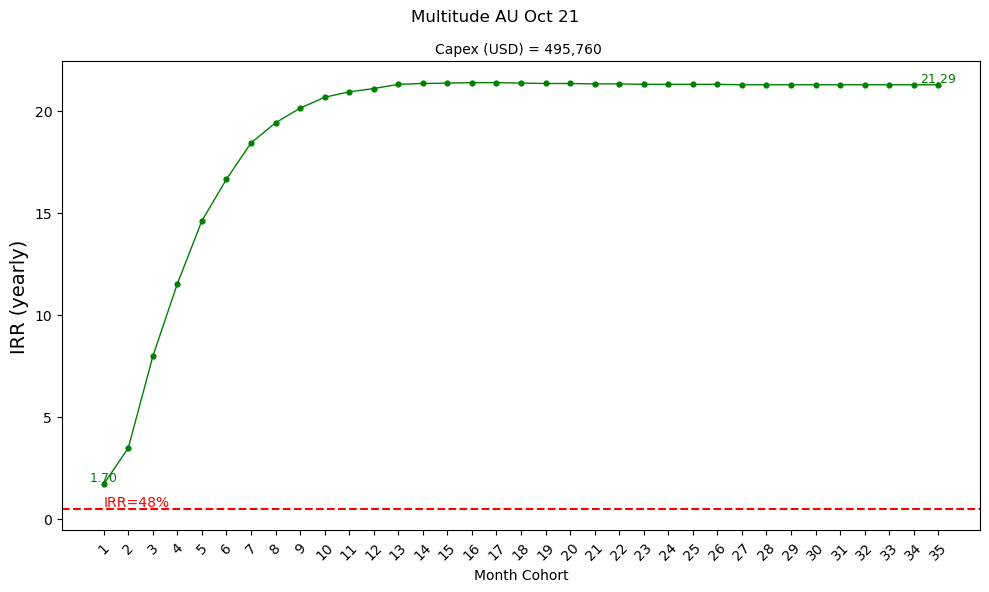

In [188]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()

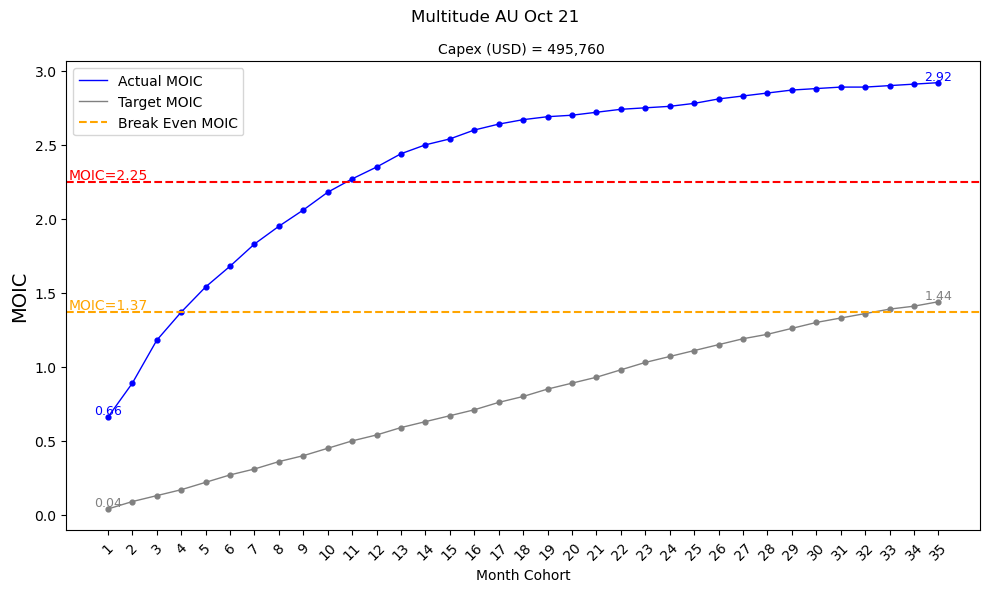

In [190]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [192]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


In [194]:
#### Recommendation Target

In [196]:
index=df_cf[df_cf.month_cohort==num_values].index[0]

In [198]:
start_index = max(0, index - 12)

In [200]:
df_cf_new_target= df_cf.iloc[start_index:index + 1][['book_id','book_name','month_cohort','actual_amount','target_prediction_amount']].copy()

In [202]:
df_cf_new_target['actual_previous_month']=df_cf_new_target['actual_amount'].shift(1)
df_cf_new_target['target_previous_month']=df_cf_new_target['target_prediction_amount'].shift(1)

In [204]:
df_cf_new_target.drop(df_cf_new_target.index[0],inplace=True)

In [206]:
df_cf_new_target['actual_month_performance']=df_cf_new_target['actual_amount']/df_cf_new_target['actual_previous_month'] -1

In [208]:
avg_12=df_cf_new_target['actual_month_performance'].mean()
median_12=df_cf_new_target['actual_month_performance'].median()

avg_6=df_cf_new_target['actual_month_performance'].tail(6).mean()
median_6=df_cf_new_target['actual_month_performance'].tail(6).median()

avg_3=df_cf_new_target['actual_month_performance'].tail(3).mean()
median_3=df_cf_new_target['actual_month_performance'].tail(3).median()

In [228]:
#print('Actual performance')
#print('avg last 12 months actual:', avg_12)
#print('median last 12 months actual:', median_12)
#print('avg last 6 months actual:', avg_6)
#print('median last 6 months actual:', median_6)
#print('avg last 3 months actual:', avg_3)
#print('median last 3 months actual:', median_3)

In [212]:
###POsitive value doesn't help. I don't need to compare trend actual last months. If it's flat, I will define the next target
### as flats? DOesn't make sense. Proposal: compare the gap between actual and target. an

In [214]:
df_cf_new_target['actual_target_gap']=df_cf_new_target['actual_amount']/df_cf_new_target['target_prediction_amount'] -1

In [216]:
avg_12=df_cf_new_target['actual_target_gap'].mean()
median_12=df_cf_new_target['actual_target_gap'].median()

avg_6=df_cf_new_target['actual_target_gap'].tail(6).mean()
median_6=df_cf_new_target['actual_target_gap'].tail(6).median()

avg_3=df_cf_new_target['actual_target_gap'].tail(3).mean()
median_3=df_cf_new_target['actual_target_gap'].tail(3).median()

In [218]:
print('Gap of actual and target')
print('avg last 12 months:', avg_12)
print('median last 12 months:', median_12)
print('avg last 6 months:', avg_6)
print('median last 6 months:', median_6)
print('avg last 3 months:', avg_3)
print('median last 3 months:', median_3)

Gap of actual and target
avg last 12 months: -0.5923471753662478
median last 12 months: -0.6469120088205191
avg last 6 months: -0.6957142198601817
median last 6 months: -0.7002636822908427
avg last 3 months: -0.6808495976441499
median last 3 months: -0.6818305691440323


In [258]:
###simiar numbers. Using avg_6
factor_decay=abs(avg_6)

In [222]:
df_next_target= df_cf.iloc[index+1:][['book_id','book_name','month_cohort','target_prediction_amount']].copy()

In [282]:
old_predict_moic=pd.concat([df_cf[df_cf.month_cohort<=num_values]['actual_amount'], df_next_target['target_prediction_amount']])
new_predict_moic=pd.concat([df_cf[df_cf.month_cohort<=num_values]['actual_amount'], df_next_target['target_prediction_amount']*factor_decay])  

In [284]:
### old predicted moic

cashflow=old_predict_moic.tolist()



#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
moic_old_full=moic[-1]

In [286]:
### new predicted moic

cashflow=new_predict_moic.tolist()



#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
moic_new_full=moic[-1]

In [304]:
current_moic=df_cf[df_cf.month_cohort==num_values]['moic'].iloc[0]

In [318]:
print('\033[1mfor others {} months in collection for book {}\033[0m'.format(len(df_cf) - num_values, df_cf['book_name'].unique()[0]))

print('local currency')
print('weight' ,abs(round(avg_6,2)))
print('original target: ',f"{int(df_next_target['target_prediction_amount'].sum()):,}")
print('avg original target per month: ',f"{int((df_next_target['target_prediction_amount'].sum())/(len(df_cf)-num_values)):,}")
print('proposed target: ', f"{int(df_next_target['target_prediction_amount'].sum()*factor_decay):,}")
print('avg proposed target: ',f"{int((df_next_target['target_prediction_amount'].sum()*factor_decay)/(len(df_cf)-num_values)):,}")
print("")
print("current moic: ",current_moic )
print("previous full moic: ",moic_old_full )
print("new full moic: ",moic_new_full )
print("Impact new target in current MOIC: {:.2%}".format(moic_new_full / current_moic - 1))

for others 85 months in collection for book Multitude AU Oct 21
local currency
weight 0.7
original target:  532,813
avg original target per month:  6,268
proposed target:  370,685
avg proposed target:  4,361

current moic:  2.92
previous full moic:  3.73
new full moic:  3.48
Impact new target in current MOIC: 19.18%


## Primagas ES Jan 2023

In [49]:
###Manual:
book_id='3791494045'

In [50]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


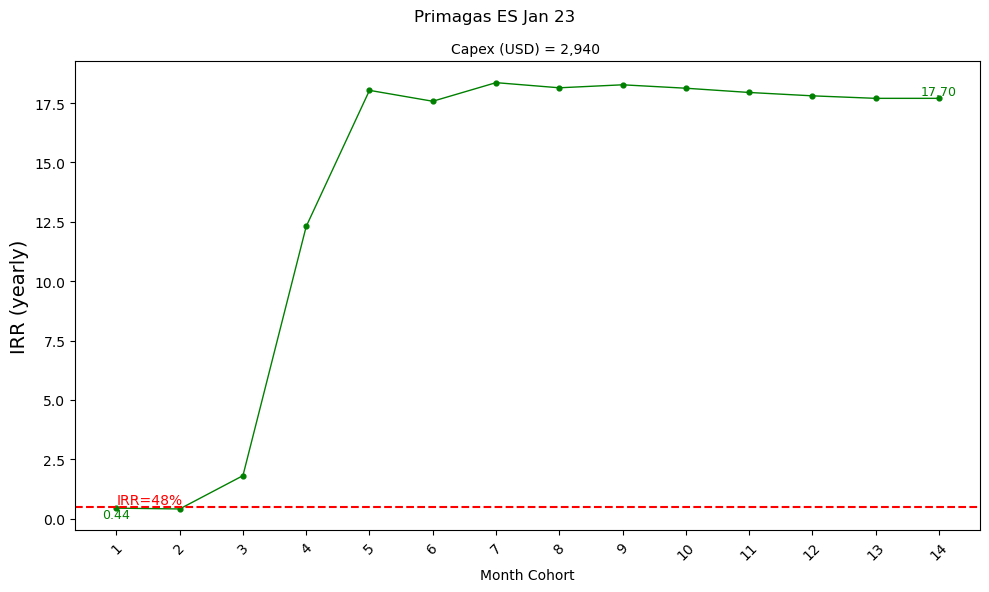

In [51]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='top', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


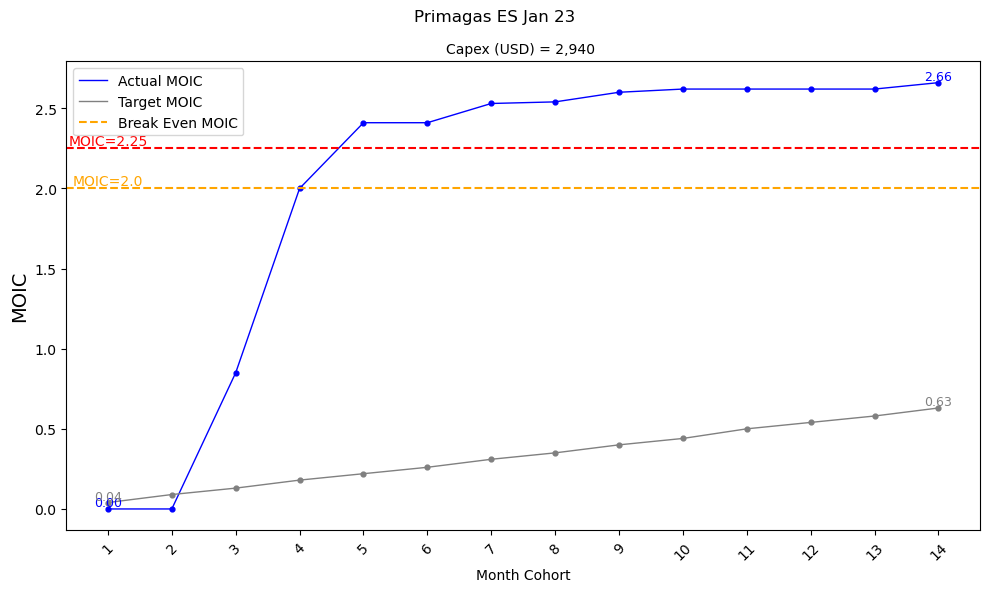

In [52]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [53]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Pagantis ES Sep 2023

In [55]:
###Manual:
book_id='5176948179'

In [56]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


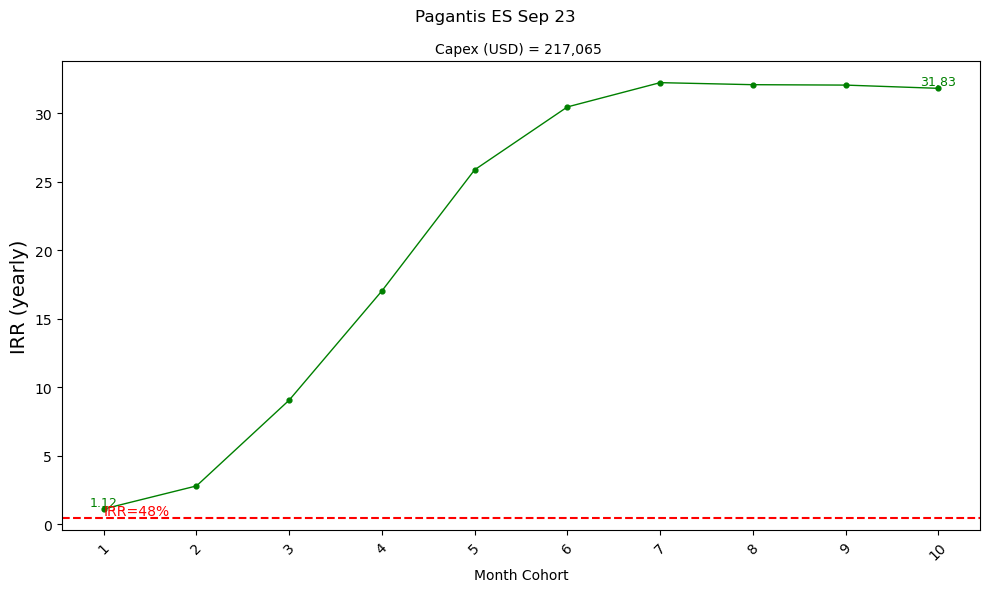

In [57]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


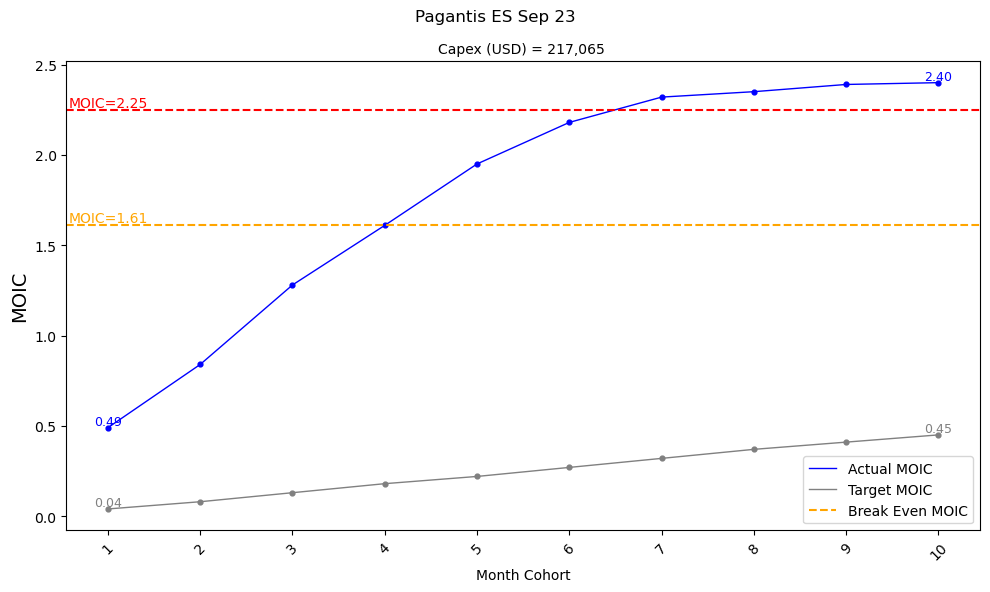

In [58]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [59]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.69


## IPF AU Sep 2023

In [61]:
###Manual:
book_id='5152696966'

In [62]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


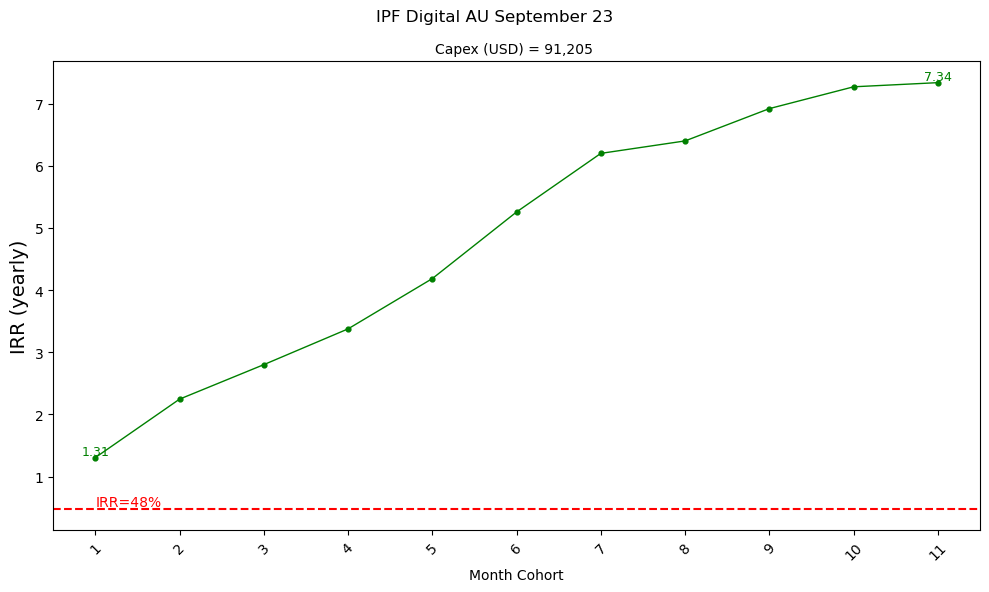

In [63]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


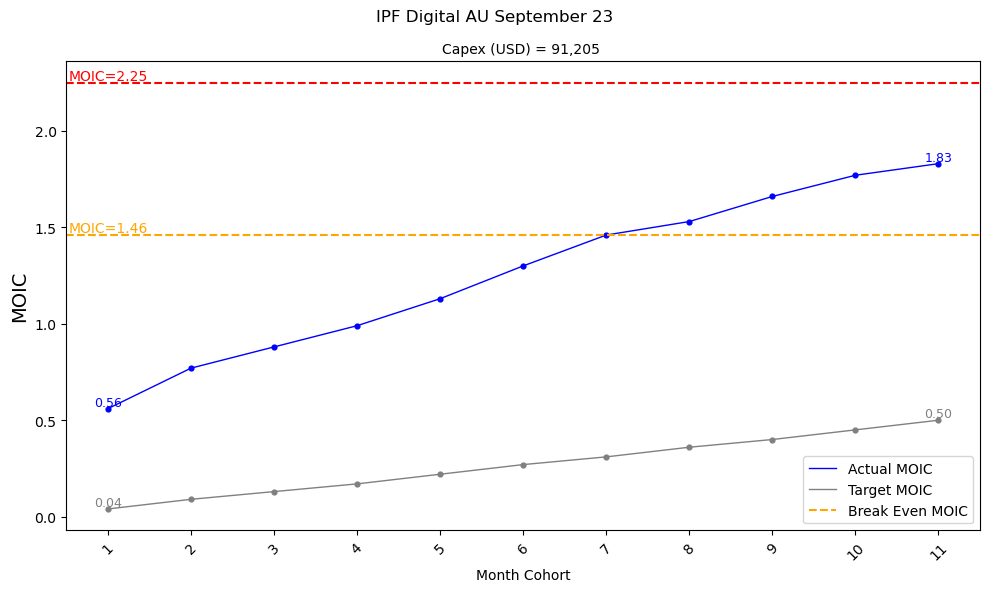

In [64]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [65]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Elysian Energy AU Aug 2023

In [67]:
###Manual:
book_id='5010243505'

In [68]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


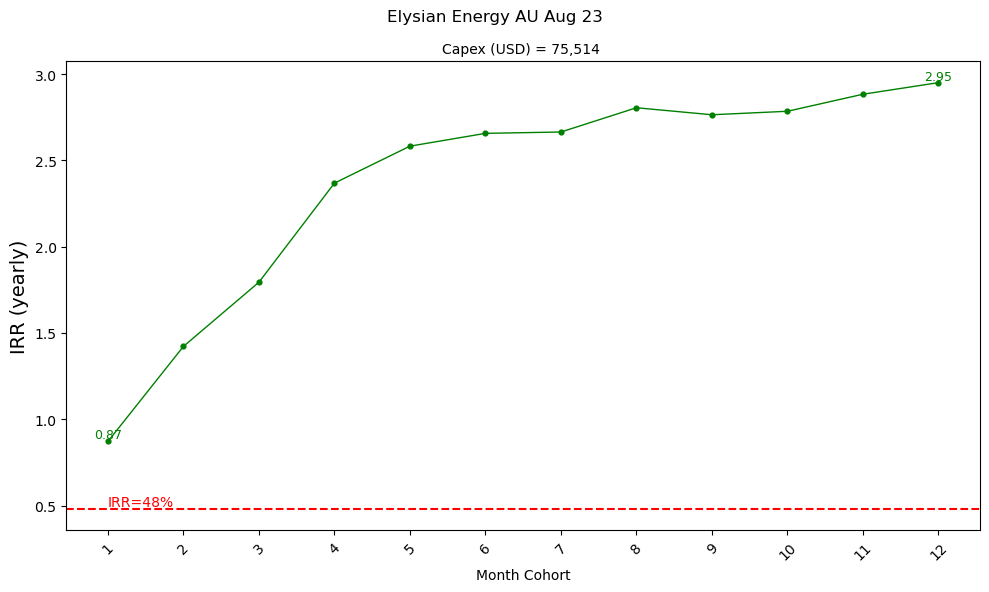

In [69]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


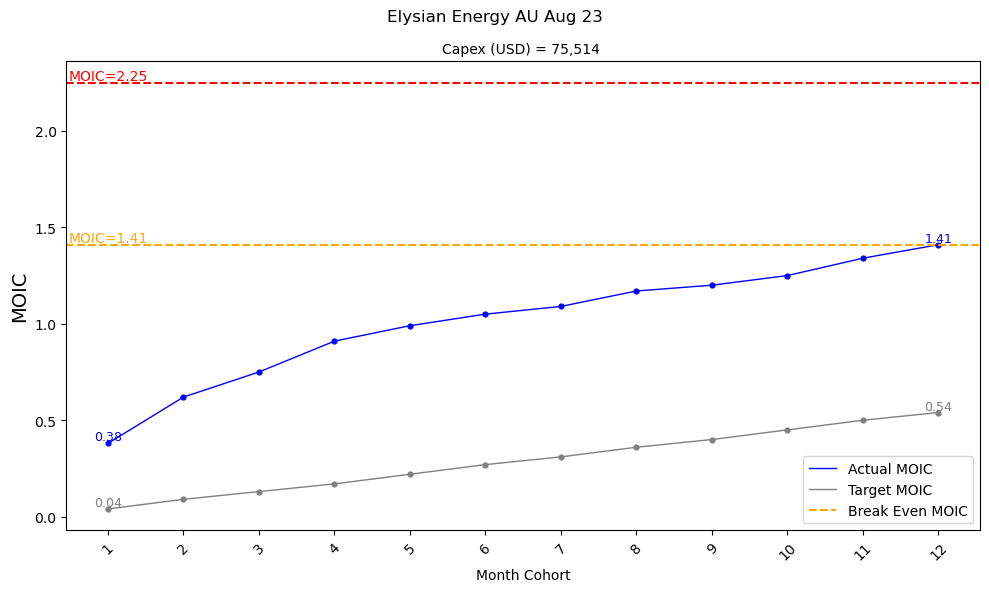

In [70]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [71]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


## Axactor ES Jul 2023

In [73]:
###Manual:
book_id='4206843141'

In [74]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [75]:

query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


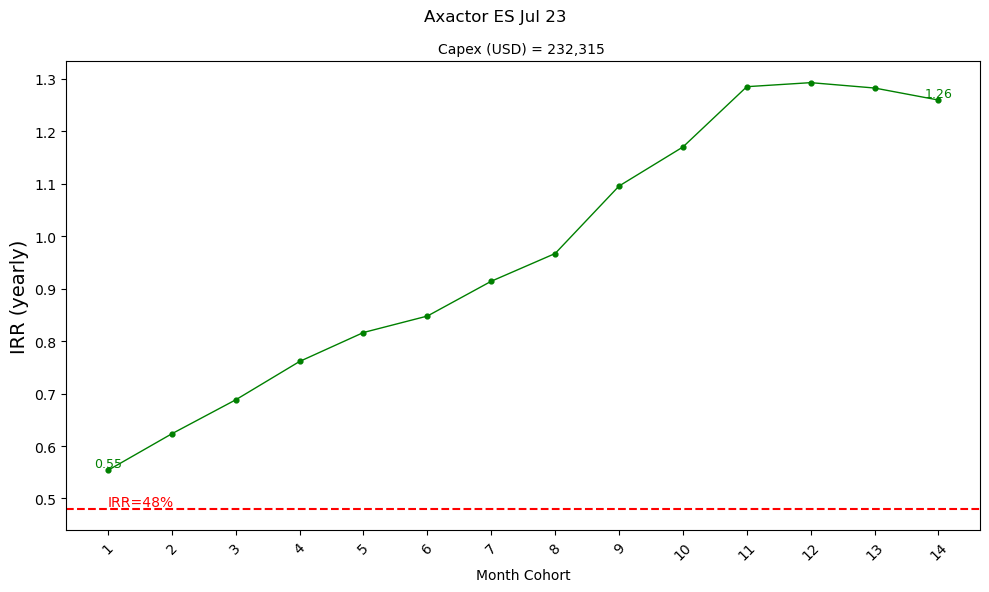

In [76]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


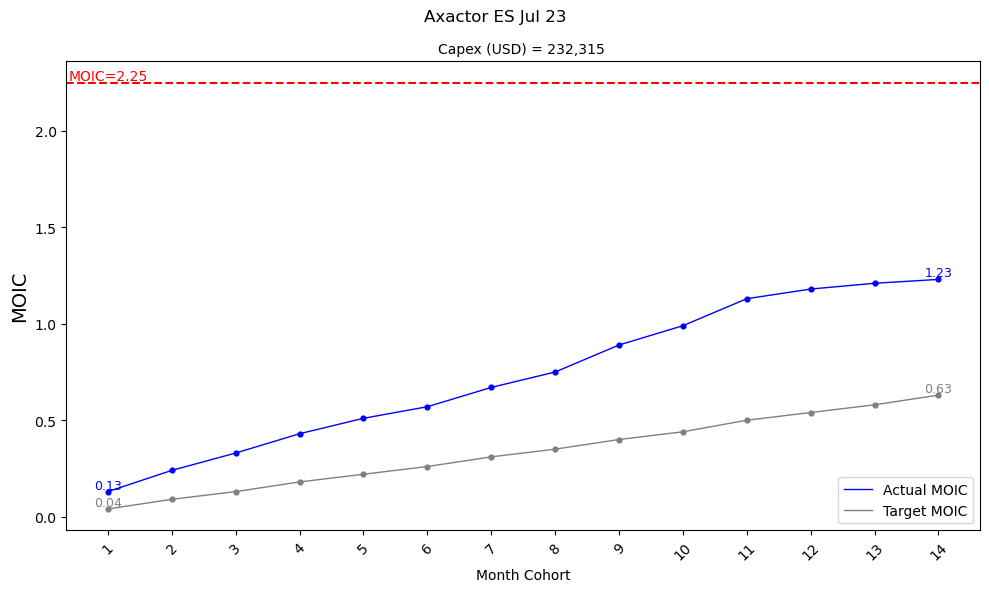

In [77]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [78]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


In [79]:
### MOIC break even assuming target payments after last current actual collection

df_cf['payments_mix'] = round(df_cf.apply(lambda row: row['actual_amount'] if row['month_cohort'] <= num_values else row['target_prediction_amount'], axis=1),2)
monthly_payments=df_cf['payments_mix'] *factor_ak_loan

monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])

###calculating moic_mix
cashflow=[]
cashflow=df_cf['payments_mix'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic_mix']=moic


moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_mix'].values[0]

print('cohort month moic break even target (collections & target): ',first_negative_balance_cohort_month_target )
print('value of moic break even target (collections & target): ',moic_break_even_target)

cohort month moic break even target (collections & target):  20
value of moic break even target (collections & target):  1.49


## Dineo ES Aug 2022

In [81]:
###Manual:
book_id='3526243721'

In [82]:
###this book didn't achieve break even on moic.
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [83]:
query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


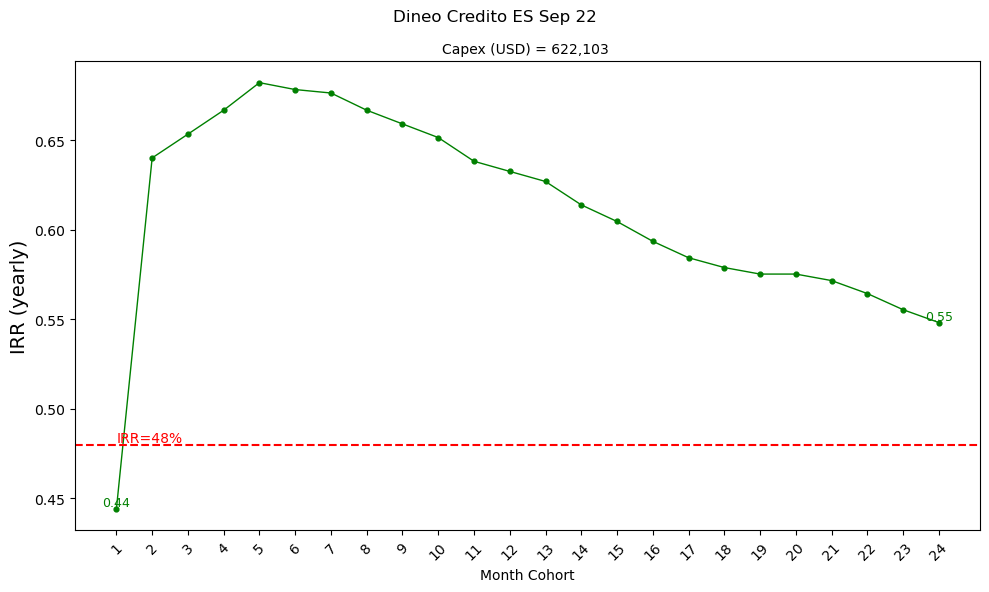

In [84]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


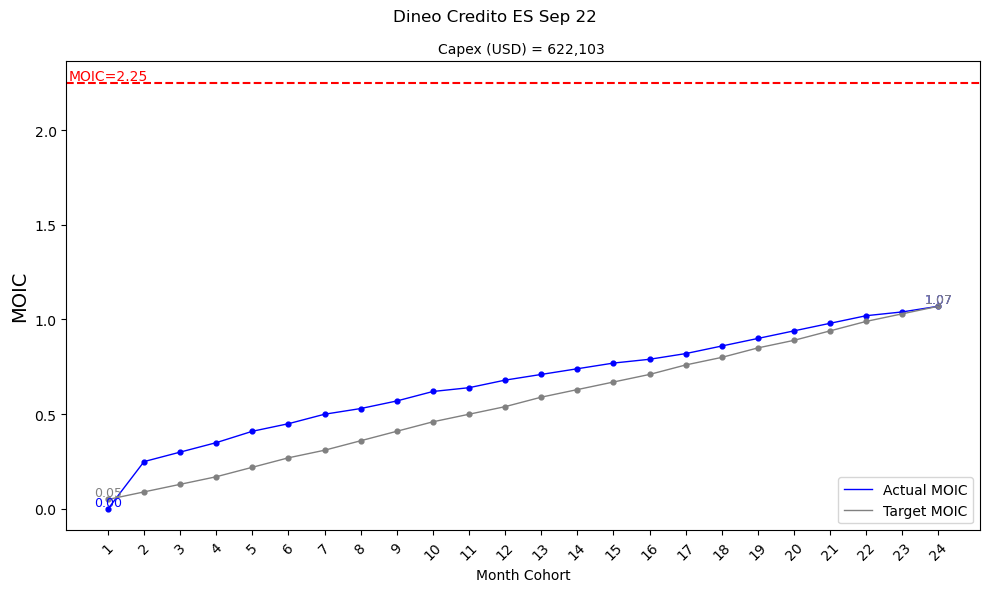

In [85]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [86]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.69


In [87]:
### MOIC break even assuming target payments after last current actual collection

df_cf['payments_mix'] = round(df_cf.apply(lambda row: row['actual_amount'] if row['month_cohort'] <= num_values else row['target_prediction_amount'], axis=1),2)
monthly_payments=df_cf['payments_mix'] *factor_ak_loan

monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])

###calculating moic_mix
cashflow=[]
cashflow=df_cf['payments_mix'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic_mix']=moic


moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_mix'].values[0]

print('cohort month moic break even target (collections & target): ',first_negative_balance_cohort_month_target )
print('value of moic break even target (collections & target): ',moic_break_even_target)

cohort month moic break even target (collections & target):  44
value of moic break even target (collections & target):  1.64


## Sumo Energy AU Jul 2024 (Pre DCA)

In [89]:
###Manual:
book_id='6977655973'

In [90]:
###this book didn't achieve break even on moic
### Verification: if df_loan['remaining_balance'].tail(1) is positive -> moic break even is not reached

In [91]:


query_purchase='''SELECT book_id,actual_purchase_price,settlement_date,round(actual_purchase_price_usd,2) actual_purchase_price_usd, Region
FROM presentation.dim_books db
where 1=1
and book_id='{}' '''.format(book_id)
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")
query_cf='''SELECT book_id,book_name,month_cohort,calendary_month, calendary_year
,coalesce(round(sum(actual_amount),2),0) actual_amount, coalesce(round(sum(actual_amount_usd),2),0) actual_amount_usd
,round(sum(target_prediction_amount),2)target_prediction_amount  ,round(sum(target_prediction_amount_usd),2) target_prediction_amount_usd
FROM presentation.fact_performance_matrics
where 1=1
and book_id='{}'
group by all
having month_cohort is not null -- and actual_amount is not null
order by month_cohort'''.format(book_id)
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")
book_name=df_cf.iloc[0,1]
### MOIC Calculation
cashflow=df_cf['actual_amount'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic']=moic 
#### Calculating Dynamic MOIC based on target
cashflow=[]
cashflow=df_cf['target_prediction_amount'].tolist()

moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)

df_cf['moic_target']=moic 
####Adding Value of P&I
price= purchase_value.copy()
monthly_rate = ((1+annual_interest_rate )**(1/12))-1
monthly_payments = round(df_cf['actual_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []
df_loan=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan = pd.DataFrame(data)

#first_negative_balance = df_loan[df_loan["remaining_balance"] < 0].iloc[0]
#first_negative_balance_cohort_month = int(first_negative_balance["cohort_month"])


### Getting moic_break_even when month_cohort=first_negative_balance_cohort_month
#moic_break_even = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month, 'moic'].values[0]

### calculating amount of actual collections
num_values=int(df_cf[(df_cf.calendary_year==last_year_collection_date) & (df_cf.calendary_month==last_month_collection_date)]['month_cohort'])

####Calculating IRR

df_cf["cum_sum_actual_amount"] = df_cf["actual_amount"].cumsum()
df_cf["cum_sum_target_prediction_amount"] = df_cf["target_prediction_amount"].cumsum()

df_cf['irr_factor_temp']=np.where(df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1<0,0,\
         df_cf.cum_sum_actual_amount/df_cf.cum_sum_target_prediction_amount-1)
		 
df_cf['remaining_months']=len(df_cf)-df_cf['month_cohort']

###last value zero
df_cf['factor_irr']=np.where(df_cf.remaining_months==0,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

###for future payments, factor =0 (only target). Not part of the graph
df_cf['factor_irr']=np.where(df_cf.month_cohort>num_values,0,df_cf['irr_factor_temp']/df_cf['remaining_months'])

##Alert indication
alert_message=''
if df_cf['factor_irr'].max()>1:
    alert_message= 'ALERT: NEGATIVE TARGET. NEED TO SHORTEN ARRAY'
else:
    alert_message= 'No alert. Good!!!'
print (alert_message)

df_cf['factor_irr_calculation']=1-df_cf['factor_irr']

df_cf['actual_amount_temp_irr_internal']=np.where(df_cf.month_cohort<=num_values,df_cf['actual_amount'],df_cf['target_prediction_amount'])

df_irr_actual=df_cf['actual_amount_temp_irr_internal'].tolist().copy()
df_irr_target=df_cf['target_prediction_amount'].tolist().copy()
df_factor_irr=df_cf['factor_irr_calculation'].tolist().copy()

num_elements = len(df_irr_actual)  

combined_lists = []
combined_lists_array=[]

for i in range(1, num_elements + 1):
    scaled_target = [x * df_factor_irr[i-1] for x in df_irr_target[i:]]
    new_list = df_irr_actual[:i] + scaled_target
    combined_lists.append(new_list)

combined_lists_array = np.array(combined_lists)

###Adding purchase as negative number

fixed_value=0
fixed_value = df_purch.iloc[0, 1] * -1

extended_lists = []
extended_lists_array=[]
for lst in combined_lists_array:
    new_list = [fixed_value] + lst.tolist()
    extended_lists.append(new_list)

extended_lists_array = np.array(extended_lists)

#####value of IRR

irr_temp=0
irr=[]
for list in extended_lists_array:
	irr_temp=round(npf.irr(list),4)
	irr.append(irr_temp)

df_cf['irr']=irr

### IRR yearly basis
irr_yearly = [(1 + rate)**12 - 1 for rate in irr]

df_cf['irr_yearly']=irr_yearly

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|
No alert. Good!!!


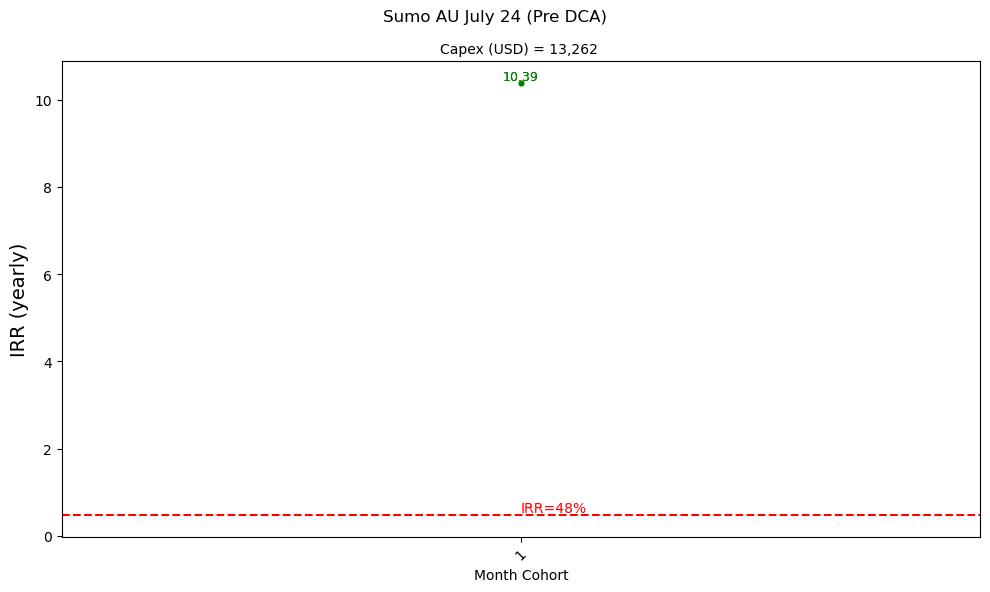

In [92]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['irr_yearly'][:num_values], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('IRR (yearly)', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Rotate x-axis labels for better readability (optional)
plt.xticks(df_cf['month_cohort'][:num_values], rotation=45)

# Annotate each point with its y-value (optional)
# for i, value in enumerate(df_cf['irr_yearly'][:num_values]):
#     plt.text(df_cf['month_cohort'][i], df_cf['irr_yearly'][i], 
#              f'{value:,.2f}', ha='center', va='bottom', fontsize=9)

# Get the last value within the limited range for annotation
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['irr_yearly'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Get the 1st value for annotation
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['irr_yearly'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='green')

# Add a line where y = 0
#plt.axhline(y=0, color='orange', linestyle='--', label='y = 0')
#plt.text(df_cf['month_cohort'].min(), 0, 'IRR=0%', color='orange', va='bottom', ha='left', fontsize=8)

# Add a line where y = 3.32% (48% yearly)
plt.axhline(y=48 * 1E-2, color='red', linestyle='--', label='y = 3.32%')
plt.text(df_cf['month_cohort'].min(), 48 * 1E-2, 'IRR=48%', color='red', va='bottom', ha='left', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


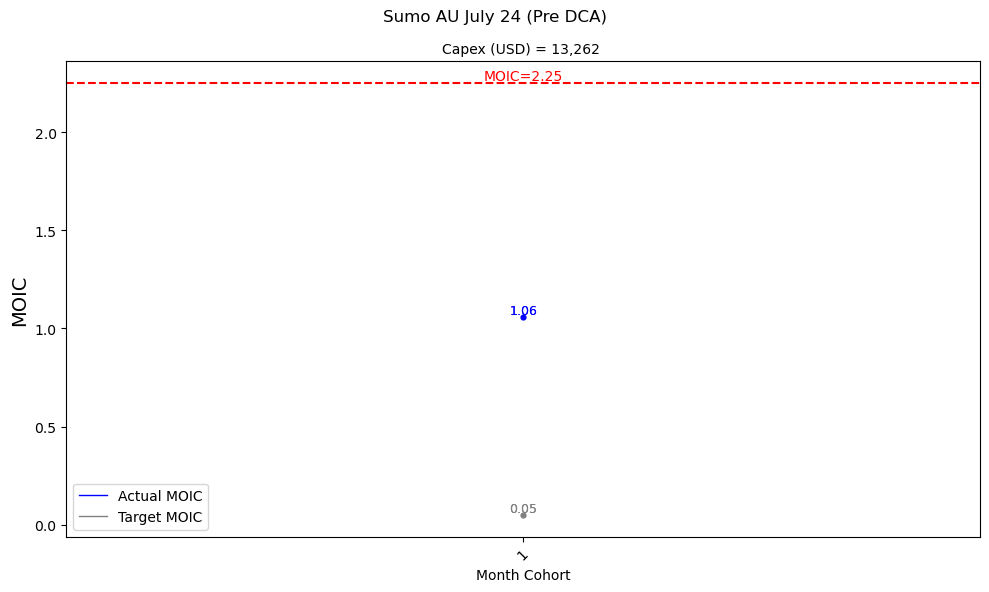

In [93]:


plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', s=12)

# Add a line connecting the dots
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic'][:num_values], color='blue', linestyle='-', linewidth=1, label='Actual MOIC')

# Add line of moic target
plt.scatter(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', s=12)
plt.plot(df_cf['month_cohort'][:num_values], df_cf['moic_target'][:num_values], color='gray', linestyle='-', linewidth=1, label='Target MOIC')

# Add labels and title
plt.xlabel('Month Cohort')
plt.ylabel('MOIC', fontsize=14)
plt.suptitle(book_name, fontsize=12)
plt.title('Capex (USD) = {:,.0f} '.format(round(df_purch.iloc[0, 3]), 0), fontsize=10)

# Get current x-axis ticks for only the selected range
ticks = df_cf['month_cohort'][:num_values]
plt.xticks(ticks, rotation=45)

# Annotate last point with its y-value within the limited range
last_x = df_cf['month_cohort'][:num_values].iloc[-1]
last_y = df_cf['moic'][:num_values].iloc[-1]
plt.text(last_x, last_y, f'{last_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate first point with its y-value
first_x = df_cf['month_cohort'].iloc[0]
first_y = df_cf['moic'].iloc[0]
plt.text(first_x, first_y, f'{first_y:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

# Annotate target MOIC last point within the limited range
last_y_target = df_cf['moic_target'][:num_values].iloc[-1]
plt.text(last_x, last_y_target, f'{last_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Annotate target MOIC first point
first_y_target = df_cf['moic_target'].iloc[0]
plt.text(first_x, first_y_target, f'{first_y_target:.2f}', ha='center', va='bottom', fontsize=9, color='gray')

# Add a line where y = 2.25
plt.axhline(y=2.25, color='red', linestyle='--', label='_nolegend_')
plt.text(df_cf['month_cohort'].min(), 2.25, 'MOIC=2.25', color='red', va='bottom', ha='center', fontsize=10)

# Add a line where y = moic_break_even
#plt.axhline(y=moic_break_even, color='orange', linestyle='--', label='Break Even MOIC')
#plt.text(df_cf['month_cohort'].min(), moic_break_even, f'MOIC={moic_break_even}', color='orange', va='bottom', ha='center', fontsize=10)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()  
plt.show()


In [94]:
### MOIC Break even target

monthly_payments = round(df_cf['target_prediction_amount']*factor_ak_loan,2)
monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])
moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_target'].values[0]

print('cohort month moic break even target: ',first_negative_balance_cohort_month_target )
print('value of moic break even target: ',moic_break_even_target)

cohort month moic break even target:  46
value of moic break even target:  1.68


In [95]:
### MOIC break even assuming target payments after last current actual collection

df_cf['payments_mix'] = round(df_cf.apply(lambda row: row['actual_amount'] if row['month_cohort'] <= num_values else row['target_prediction_amount'], axis=1),2)
monthly_payments=df_cf['payments_mix'] *factor_ak_loan

monthly_payments=monthly_payments.tolist()
remaining_balance = price
data = []


df_loan_target=pd.DataFrame()
for month, payment in enumerate(monthly_payments, start=1):
    interest_payment = remaining_balance * monthly_rate
    principal_payment = payment - interest_payment
    remaining_balance -= principal_payment
    data.append({
        "cohort_month": month,
        "monthly_payment": payment,
        "principal_payment": principal_payment,
        "interest_payment": interest_payment,
        "remaining_balance": remaining_balance
    })

df_loan_target = pd.DataFrame(data)


first_negative_balance_target = df_loan_target[df_loan_target["remaining_balance"] < 0].iloc[0]

first_negative_balance_cohort_month_target = int(first_negative_balance_target["cohort_month"])

###calculating moic_mix
cashflow=[]
cashflow=df_cf['payments_mix'].tolist()
#### Calculating Dynamic MOIC
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(0, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_cf['moic_mix']=moic


moic_break_even_target = df_cf.loc[df_cf['month_cohort'] == first_negative_balance_cohort_month_target, 'moic_mix'].values[0]

print('cohort month moic break even target (collections & target): ',first_negative_balance_cohort_month_target )
print('value of moic break even target (collections & target): ',moic_break_even_target)

cohort month moic break even target (collections & target):  8
value of moic break even target (collections & target):  1.37
